<a href="https://colab.research.google.com/github/erdult/Fine-Tune-LLM/blob/main/Sentiment_analysis_Quick_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Import packages

In [3]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")

print("Path to dataset files:", path)

100%|██████████| 276k/276k [00:00<00:00, 446kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sbhatti/financial-sentiment-analysis/versions/4


In [5]:
import pandas as pd

df = pd.read_csv(path + '/data.csv',
                 encoding="utf-8", encoding_errors="replace")

In [6]:
df.columns = ["text", "sentiment"]

In [7]:
df.head()

,text,sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [77]:
df.sentiment.value_counts()

,count
sentiment,
neutral,3130
positive,1852
negative,860


Sample from each type of sentiment a

In [8]:
X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment],
                                    train_size=300,
                                    test_size=300,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(X_train.index) + list(X_test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

Let's check we got this right.

In [9]:
X_train.shape, X_eval.shape, X_test.shape

((900, 2), (150, 2), (900, 2))

CountVectorizer is a powerful tool in scikit-learn for text analysis. Its primary function is to convert a collection of text documents into a matrix of token counts. This transformation is crucial for applying machine learning algorithms to text data.

Here's a breakdown of how it works:

Text Preprocessing:

It starts by tokenizing the input text, breaking it down into individual words or phrases (n-grams).
It builds a vocabulary of all the unique tokens found in the documents.
Document-Term Matrix Creation:

It creates a matrix where each row represents a document and each column represents a token from the vocabulary.
The values in the matrix indicate the frequency of each token in each document.


SGDClassifier stands for Stochastic Gradient Descent Classifier. It's a linear classifier in the scikit-learn library that utilizes stochastic gradient descent (SGD) for training. This means it iteratively updates the model's parameters using a small subset of the training data (a mini-batch) at a time.

In [10]:
X_train

,text,sentiment
0,"Operating profit totalled EUR 9.6 mn , down fr...",neutral
1,"As part of the transaction , M-real and Sappi ...",positive
2,$SBUX heading for the 200DMA and certain doom ...,negative
3,Operating profit increased to EUR 14.0 mn from...,positive
4,Long $TSLA short $MBLY https://t.co/jSpUSzo6na,positive
...,...,...
895,"The highest growth would be in China , while w...",neutral
896,Vacon controls a further 5 % of the company vi...,neutral
897,Cargotec 's sales totalled EUR 3.4 billion in ...,neutral
898,"In the fourth quarter of 2009 , Orion 's net p...",positive


In [11]:
# Prepare necessary packages
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [12]:
SD_clf = Pipeline([('cv', CountVectorizer(ngram_range=(1,2),stop_words=None)),('clf',  SGDClassifier(class_weight = 'balanced',max_iter=10000,n_iter_no_change=10))])
y_true = X_train.sentiment
SD_clf.fit(X_train.text,y_true)

Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('clf',
                 SGDClassifier(class_weight='balanced', max_iter=10000,
                               n_iter_no_change=10))])

In [13]:
SD_clf.score(X_test.text,X_test.sentiment)

0.5888888888888889

In [14]:
y_test_pred = SD_clf.predict(X_test.text)
pd.DataFrame(classification_report(y_test_pred,X_test.sentiment,output_dict=True)).T

,precision,recall,f1-score,support
negative,0.556667,0.609489,0.581882,274.000000
neutral,0.773333,0.532110,0.630435,436.000000
positive,0.436667,0.689474,0.534694,190.000000
accuracy,0.588889,0.588889,0.588889,0.588889
macro avg,0.588889,0.610358,0.582337,900.000000
weighted avg,0.636296,0.588889,0.595441,900.000000


In [15]:
X_test.sentiment.value_counts()

,count
sentiment,
positive,300
neutral,300
negative,300


# Now we will try to use RNN with pytorch to estimate multiclass classification

In [16]:
#Prepare environment for pytorch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [17]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [18]:
from nltk.corpus import stopwords
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])
    # create encoded train positive, 2, neutral 1 and negative 0, this is ordinal encoding!!!
    encoded_train =   y_train.map({'positive': 2, 'neutral': 1, 'negative': 0}).tolist()
    encoded_test =   y_val.map({'positive': 2, 'neutral': 1, 'negative': 0}).tolist()
    return final_list_train, np.array(encoded_train),final_list_test, np.array(encoded_test),onehot_dict


In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
X_train.sentiment

,sentiment
0,neutral
1,positive
2,negative
3,positive
4,positive
...,...
895,neutral
896,neutral
897,neutral
898,positive


In [21]:
x_train,y_train,x_test,y_test,vocab = tockenize(X_train.text,X_train.sentiment,X_test.text,X_test.sentiment)

In [22]:
x_train[:2]

[[12, 4, 41, 1, 2, 1, 2, 13],
 [86, 135, 300, 794, 32, 136, 396, 51, 122, 301, 302, 39, 795]]

In [23]:
# padding to make sure all inputs have same length
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

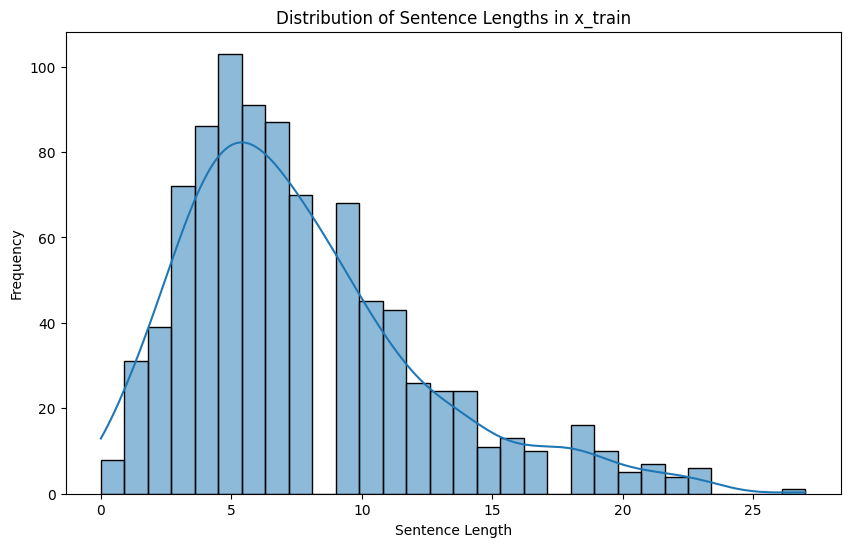

Sentence Length
0       8
1      31
2      39
3      72
4      86
5     103
6      91
7      87
8      70
9      68
10     45
11     43
12     26
13     24
14     24
15     11
16     13
17     10
18     16
19     10
20      5
21      7
22      4
23      6
27      1
Name: Sentence Length, dtype: int64


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate sentence lengths
sentence_lengths = [len(sentence) for sentence in x_train]

# Create a distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)  # Adjust 'bins' for granularity
plt.title("Distribution of Sentence Lengths in x_train")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

# Create a DataFrame for the distribution
length_distribution = pd.DataFrame({'Sentence Length': sentence_lengths})

# Group by length and count frequencies
length_counts = length_distribution.groupby('Sentence Length')['Sentence Length'].count()

# Display the table
print(length_counts)

In [25]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,30)
x_test_pad = padding_(x_test,30)

In [26]:
x_train_pad[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  12,   4,  41,   1,
          2,   1,   2,  13],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  86, 135, 300, 794,  32, 136, 396,  51, 122,
        301, 302,  39, 795]])

In [27]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [28]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 30])
Sample input: 
 tensor([[  0,   0,   0,  ..., 750, 667, 198],
        [  0,   0,   0,  ...,   2, 137,  11],
        [  0,   0,   0,  ...,   2,   1,   2],
        ...,
        [  0,   0,   0,  ..., 383, 111, 280],
        [  0,   0,   0,  ...,  11, 725, 227],
        [  0,   0,   0,  ..., 433, 747, 120]])
Sample input: 
 tensor([1, 0, 0, 2, 2, 1, 1, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 2, 1,
        0, 2, 0, 2, 1, 0, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2,
        1, 0])


In [29]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # # sigmoid function
        # sig_out = self.sig(out)

        # Reshape output to batch_size x output_dim
        out = out.view(batch_size, -1, self.output_dim)
        out = out[:, -1, :]  # Take the last output for each sequence

        # return last sigmoid output and hidden state
        return out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [66]:
no_layers = 3
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 128
output_dim = 3
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 128)
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [67]:
# loss and optimization functions
lr=0.001

# The loss function is changed from BCELoss (Binary Cross-Entropy Loss) to CrossEntropyLoss. This is because we are doing
# multi-class classification (positive, neutral, negative), and CrossEntropyLoss is more suitable for this scenario.
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy.
def acc(pred,label):
    pred = torch.argmax(pred, dim=1)
    return torch.sum(pred == label).item()

In [68]:
import os

# Create the 'working' directory if it doesn't exist. This is needed to store state dictionary
os.makedirs('../working', exist_ok=True)

In [69]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()



    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.long())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)

            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 1.1012009514702692 val_loss : 1.091737084918552
train_accuracy : 34.11111111111111 val_accuracy : 37.111111111111114
Validation loss decreased (inf --> 1.091737).  Saving model ...
Epoch 2
train_loss : 1.0744386977619595 val_loss : 1.0702537099520366
train_accuracy : 43.77777777777778 val_accuracy : 42.22222222222222
Validation loss decreased (1.091737 --> 1.070254).  Saving model ...
Epoch 3
train_loss : 0.9678397609127892 val_loss : 1.0496472318967183
train_accuracy : 53.333333333333336 val_accuracy : 44.55555555555556
Validation loss decreased (1.070254 --> 1.049647).  Saving model ...
Epoch 4
train_loss : 0.7768918176492056 val_loss : 1.1324351065688663
train_accuracy : 65.66666666666666 val_accuracy : 49.22222222222222
Epoch 5
train_loss : 0.6352993183665805 val_loss : 1.1733197106255426
train_accuracy : 72.11111111111111 val_accuracy : 50.22222222222222


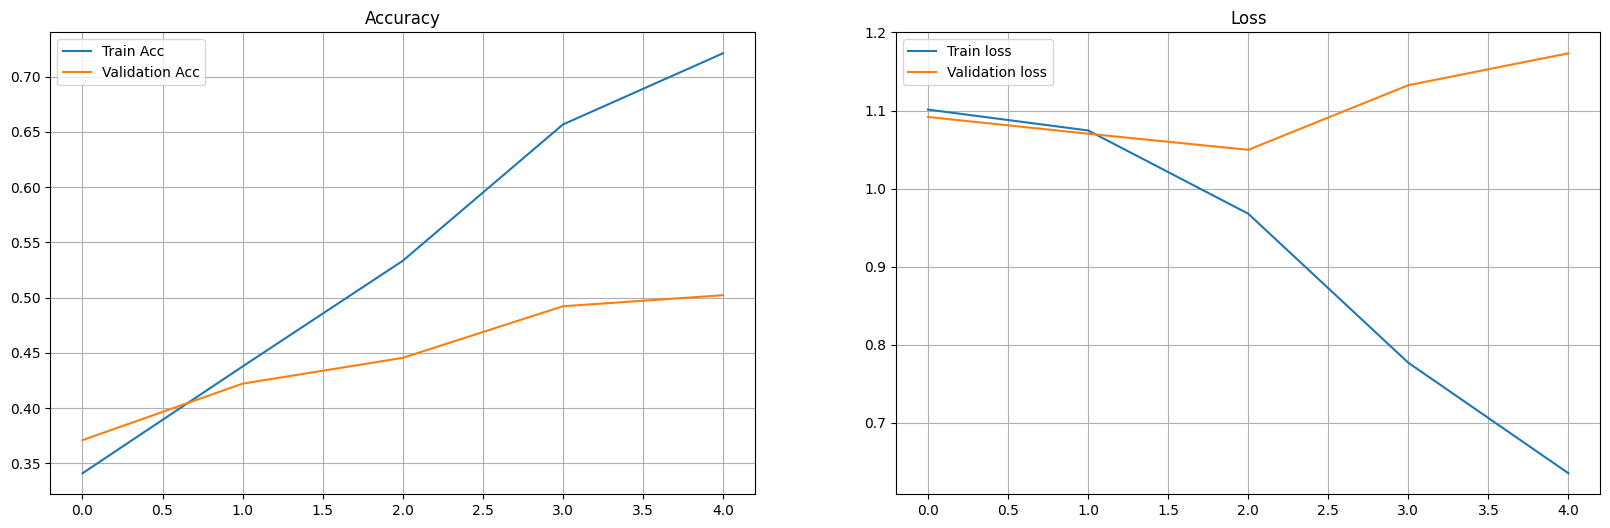

In [70]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [71]:
best_model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
best_model.to(device)
best_model.load_state_dict(torch.load('../working/state_dict.pt'))

 #Put the loaded model in evaluation mode
best_model.eval()

SentimentRNN(
  (embedding): Embedding(1001, 128)
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [72]:
# import the missing function
import torch.nn.functional as F

def predict_text(text, model):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                     if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,30)) # changed to 30
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    # Use softmax to get probabilities and then find the index of the maximum value
    probs = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    return predicted_class

In [76]:
index = 10
print(df.shape)
print(df['text'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['text'][index], best_model)


# print(F.softmax(pro, dim=1))

#round to closest integer
# pro = round(pro)

print(pro)
pro = round(pro)
if pro >= 1.5:
  status = 'positive'
elif pro <=0.5:
  status = 'negative'
else:
  status = 'neutral'

print(f'Predicted sentiment is {status} with a probability of {pro}')

(5842, 2)
Circulation revenue has increased by 5 % in Finland and 4 % in Sweden in 2008 .
Actual sentiment is  : positive
0
Predicted sentiment is negative with a probability of 0


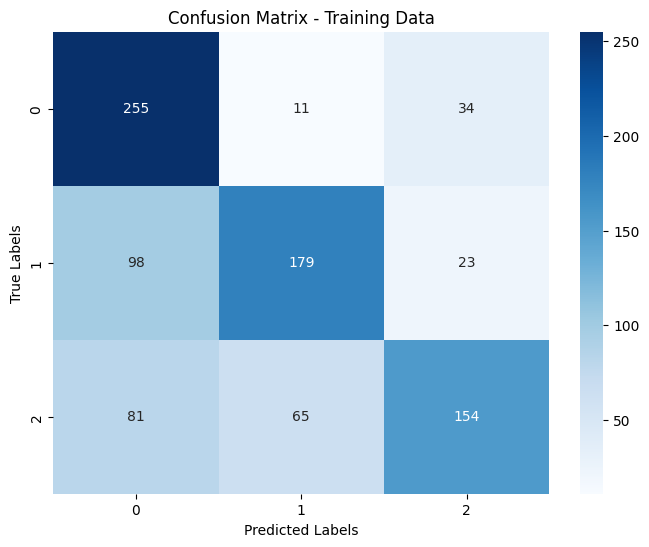

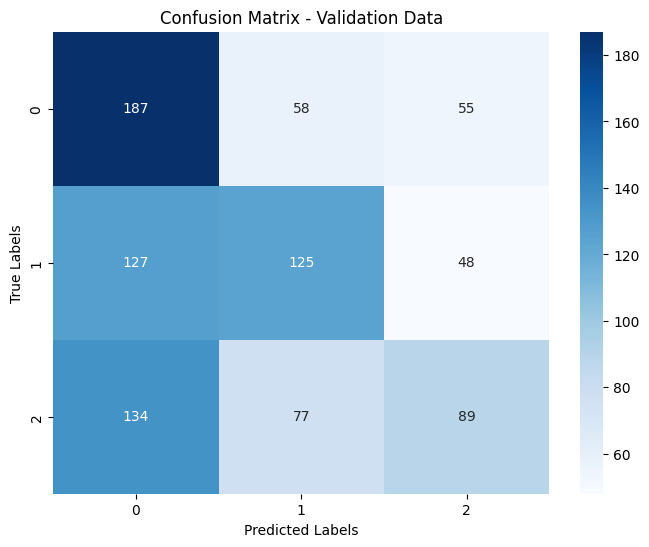

In [74]:
# Function to predict labels for a dataset
def predict_dataset(data_loader, model):
    all_preds = []
    all_labels = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = model.init_hidden(inputs.size(0))
            h = tuple([each.data for each in h])
            output, h = model(inputs, h)
            probs = F.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for the training and validation datasets
train_preds, train_labels = predict_dataset(train_loader, best_model)
valid_preds, valid_labels = predict_dataset(valid_loader, best_model)

# Generate confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
valid_cm = confusion_matrix(valid_labels, valid_preds)

# Plotting function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot the confusion matrices
plot_confusion_matrix(train_cm, 'Confusion Matrix - Training Data')
plot_confusion_matrix(valid_cm, 'Confusion Matrix - Validation Data')